In [207]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pylab
import seaborn as sns
import os
from os import path
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from scipy.cluster.hierarchy import fcluster, fclusterdata, linkage, dendrogram 
import matplotlib.patches as patches
from copy import deepcopy
import pickle

# common formatting
plt.style.use('../../synthetic-enhancer-footprinting.mplstyle')

import sys  
# sys.path.insert(0, '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/code/amplicon-smf/workflow/scripts')
sys.path.insert(0, '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/partition_function_model_outputs/231114_first_pass_at_reunning_everything/amplicon-smf/workflow/scripts')

import common, fit_partition_function_model_v3


import importlib
importlib.reload(common)
importlib.reload(fit_partition_function_model_v3)
%matplotlib inline

import matplotlib.font_manager

output_path = '/oak/stanford/groups/wjg/jschaepe/projects/smf/synthetic-enhancer-footprinting-outputs/'

fontsize=6
markersize=20
legend_fontsize = 5

import gzip


In [208]:
# here is where the atac processing lives: $OAK/jschaepe/projects/atac/20220921_julia_IFN/23.08.08_IFN_ATAC_dataset
# the snake atac output is in 20220921_julia_IFN/snakeATAC_sing
# rna data and processing lives here: $OAK/jschaepe/projects/rna/230810_IFN_RNAseq
# motifs from georgi: /oak/stanford/groups/akundaje/marinovg/motifs/FIMO-CIS-BP-Homo_sapiens.hg20.fimo.txt.annotated.bgz
# greenleaf tss: /oak/stanford/groups/wjg/share/resources/hg38/hg38.tss.bed
# engreitz tss: /oak/stanford/groups/wjg/bgrd/data/genomes/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed
# bash commands live here: /oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/ifn_analyses/
basedir = '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/ifn_analyses/231219_ifn_analyses'

In [209]:
# first step is to make confident TSS annotations for ISGs
de_genes_file = '/oak/stanford/groups/wjg/jschaepe/projects/rna/230810_IFN_RNAseq/DEseq_results.csv'
de_genes = pd.read_csv(de_genes_file, index_col=0)

# select just the ones that go up
p_thresh = 0.05
l2fc_thresh = 1

isgs = de_genes.loc[(de_genes.padj < p_thresh)&(de_genes.log2FoldChange > l2fc_thresh)]
isg_ids = isgs.index.tolist()
print(len(isg_ids))
isgs.head()

182


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
ENSG00000186470,337.825087,1.000515,0.236025,4.239014,2.245036e-05,1.570321e-03,BTN3A2
ENSG00000101986,544.339916,1.008387,0.191130,5.275932,1.320827e-07,1.339612e-05,ABCD1
ENSG00000135047,3707.473685,1.011592,0.126569,7.992426,1.323086e-15,2.156630e-13,CTSL
ENSG00000184898,342.332715,1.029239,0.223054,4.614299,3.944235e-06,3.130694e-04,RBM43
ENSG00000198959,6360.183030,1.038980,0.133317,7.793289,6.528702e-15,1.027483e-12,TGM2


In [210]:
# one way is to load hg38 tss file from wjg atac pipeline
# tss
wjg_tss_file = '/oak/stanford/groups/wjg/share/resources/hg38/hg38.tss.bed'
wjg_tss = pd.read_table(wjg_tss_file, header=None)
isg_tss = wjg_tss.loc[wjg_tss[5].isin(isgs.symbol)]
isg_tss.to_csv(path.join(basedir, 'isg_tss.wjg.bed'), sep='\t', header=False, index=False)
print(len(isg_tss))
isg_tss.head()

1243


,0,1,2,3,4,5
135,chr1,999980,999981,-,uc057ayp.1,HES4
136,chr1,1000095,1000096,-,uc057ayo.1,HES4
137,chr1,1000110,1000111,-,uc001aci.3,HES4
138,chr1,1000171,1000172,-,uc010nyc.1,HES4
139,chr1,1001137,1001138,+,uc057ayq.1,ISG15


In [211]:
# another way is to load the engreitz annotation, and try joining either on ensembl or symbol
abc_tss_file = '/oak/stanford/groups/wjg/bgrd/data/genomes/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed'
abc_tss = pd.read_table(abc_tss_file)
isg_tss_symbol = abc_tss.loc[abc_tss['name'].isin(isgs.symbol)]
isg_tss_ensembl = abc_tss.loc[abc_tss['Ensembl_ID'].isin(isg_ids)]
isg_tss_symbol.to_csv(path.join(basedir, 'isg_tss.engreitz_symbol.bed'), sep='\t', header=False, index=False)
isg_tss_ensembl.to_csv(path.join(basedir, 'isg_tss.engreitz_ensembl.bed'), sep='\t', header=False, index=False)
print(len(isg_tss_symbol))
print(len(isg_tss_ensembl))
isg_tss_symbol.head()

158
162


,#chr,start,end,name,score,strand,Ensembl_ID,gene_type
12,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding
13,chr1,1013216,1013716,ISG15,0,+,ENSG00000187608,protein_coding
67,chr1,2556114,2556614,TNFRSF14,0,+,ENSG00000157873,protein_coding
285,chr1,21290239,21290739,ECE1,0,-,ENSG00000117298,protein_coding
393,chr1,27671963,27672463,IFI6,0,-,ENSG00000126709,protein_coding


In [212]:
# get null genes
f = path.join(basedir, '20221129_normalized_tpm_counts.csv')
tpm = pd.read_csv(f, index_col=0)
tpm['no_ifn_tpm'] = tpm[['K562_WT_noTX_BR1_S5','K562_WT_noTX_BR2_S6']].mean(axis=1)
tpm.head()

l2fc_thresh_null = 0.5

no_change_genes = de_genes.loc[de_genes.log2FoldChange.between(-1*l2fc_thresh_null,l2fc_thresh_null)].index.tolist()

null_genes = []

for isg in isg_ids:
    basemean = tpm.loc[isg,'no_ifn_tpm']
    null_gene = np.abs(tpm.loc[no_change_genes,'no_ifn_tpm'] - basemean).sort_values().index[0]
    null_genes.append(null_gene)
    
null_tss_ensembl = abc_tss.loc[abc_tss['Ensembl_ID'].isin(null_genes)].copy()
null_tss_ensembl.to_csv(path.join(basedir, 'null_tss.engreitz_ensembl.bed'), sep='\t', header=False, index=False)

In [213]:
# now go do stuff in the notebook

In [220]:
motifs = ['STAT1', 'STAT2', 'IRF9']

dfs = []

for motif in motifs:
    f = path.join(basedir, 'isg_tss.engreitz_ensembl.{}.counts'.format(motif))
    df = pd.read_table(f, header=None, names=['chr','start','end','gene','.','strand','id','type',motif])
    dfs.append(df)

isg_df = dfs[0].merge(dfs[1], on='gene', suffixes=['','_1']).merge(dfs[2], on='gene', suffixes=['','_2'])[['chr','start','end','gene','.','strand','id','type']+motifs]
isg_df['motif_sum'] = isg_df[motifs].sum(axis=1)
isg_df['motif_max'] = isg_df[motifs].max(axis=1)
isg_df['stat2_irf9'] = isg_df[['STAT2', 'IRF9']].max(axis=1)

# now do for null
null_dfs = []

for motif in motifs:
    f = path.join(basedir, 'null_tss.engreitz_ensembl.{}.counts'.format(motif))
    df = pd.read_table(f, header=None, names=['chr','start','end','gene','.','strand','id','type',motif])
    null_dfs.append(df)

null_df = null_dfs[0].merge(null_dfs[1], on='gene', suffixes=['','_1']).merge(null_dfs[2], on='gene', suffixes=['','_2'])[['chr','start','end','gene','.','strand','id','type']+motifs]
null_df['motif_sum'] = null_df[motifs].sum(axis=1)
null_df['motif_max'] = null_df[motifs].max(axis=1)
null_df['stat2_irf9'] = null_df[['STAT2', 'IRF9']].max(axis=1)

isg_df.head(), null_df.head()

(    chr     start       end      gene  . strand               id  \
 0  chr1    999922   1000422      HES4  0      -  ENSG00000188290   
 1  chr1   1013216   1013716     ISG15  0      +  ENSG00000187608   
 2  chr1   2556114   2556614  TNFRSF14  0      +  ENSG00000157873   
 3  chr1  21290239  21290739      ECE1  0      -  ENSG00000117298   
 4  chr1  27671963  27672463      IFI6  0      -  ENSG00000126709   
 
              type  STAT1  STAT2  IRF9  motif_sum  motif_max  stat2_irf9  
 0  protein_coding      0      0     0          0          0           0  
 1  protein_coding      0      4     1          5          4           4  
 2  protein_coding      0      2     0          2          2           2  
 3  protein_coding      0      0     0          0          0           0  
 4  protein_coding      0      3     3          6          3           3  ,
     chr      start        end      gene  . strand               id  \
 0  chr1    3624741    3625241    TPRG1L  0      +  ENSG000001

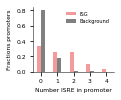

In [221]:
fig, ax = plt.subplots(figsize=(4/2.5,3/2.5))

isg_color = '#F6999B'
null_color = '0.5'
sixhr_color = '#d51317'

col = 'stat2_irf9'

df = pd.DataFrame({'ISG': isg_df[col].value_counts(normalize=True), 'Background': null_df[col].value_counts(normalize=True)})

df.plot.bar(ax=ax, rot=0, color = [isg_color, null_color])

ax.set_xlabel('Number ISRE in promoter', fontsize = fontsize)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([0,1,2,3,4], fontsize = fontsize)
ax.set_ylabel('Fractions promoters', fontsize = fontsize)
# ax.set_ylim(0.05,0.55)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8], fontsize = fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_box_aspect(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.get_legend().set_visible(False)
plt.legend(fontsize=legend_fontsize, markerscale=0.5, frameon=False, title='', title_fontsize=legend_fontsize, bbox_to_anchor=(1,1))

plt.savefig('{}/fig4_plots/fig4_supplement/isre_matches_at_isgs.pdf'.format(output_path), dpi=300)



In [222]:
motif_thresh = 2

bonafide_isgs = isg_df.loc[isg_df[col] > motif_thresh,'gene'].tolist()
bonafide_isgs_ids = isg_df.loc[isg_df[col] > motif_thresh,'id'].tolist()

bonafide_null_genes = []

null_to_isg_map = {}

for isg in bonafide_isgs_ids:
    basemean = tpm.loc[isg,'no_ifn_tpm']
    null_gene = np.abs(tpm.loc[no_change_genes,'no_ifn_tpm'] - basemean).sort_values().index[0]
    bonafide_null_genes.append(null_gene)
    null_to_isg_map[null_gene] = isg


In [223]:
samples = ['JMS-0IFN-b1','JMS-0IFN-b2',]
samples_6hr = ['JMS-6IFN-b1','JMS-6IFN-b2']

read_depths = {'JMS-0IFN-b1': 16539520, 
               'JMS-0IFN-b2': 19947866, 
               'JMS-6IFN-b1': 24661726, 
               'JMS-6IFN-b2': 21147274}

dfs = []

for samp in samples:
    f = path.join(basedir, '{}.isg_tss.engreitz_ensembl.counts'.format(samp))
    df = pd.read_table(f, header=None, names=['chr','start','end','gene','.','strand','id','type','pos',samp])
    df['{}_rpm'.format(samp)] = df[samp] / read_depths[samp] * 1e6
    dfs.append(df)

isg_df = dfs[0].merge(dfs[1], on=['gene','pos'], suffixes=['','_1'])[['chr','start','end','gene','.','strand','id','type','pos']+samples+[s+'_rpm' for s in samples]]
isg_df['rpm'] = isg_df.filter(like='rpm').mean(axis=1)

# now for null
null_dfs = []

for samp in samples:
    f = path.join(basedir, '{}.null_tss.engreitz_ensembl.counts'.format(samp))
    df = pd.read_table(f, header=None, names=['chr','start','end','gene','.','strand','id','type','pos',samp])
    df['{}_rpm'.format(samp)] = df[samp] / read_depths[samp] * 1e6
    null_dfs.append(df)

null_df = null_dfs[0].merge(null_dfs[1], on=['gene','pos'], suffixes=['','_1'])[['chr','start','end','gene','.','strand','id','type','pos']+samples+[s+'_rpm' for s in samples]]
null_df['rpm'] = null_df.filter(like='rpm').mean(axis=1)

# now do 6hr IFN
sixhr_dfs = []

for samp in samples_6hr:
    f = path.join(basedir, '{}.isg_tss.engreitz_ensembl.counts'.format(samp))
    df = pd.read_table(f, header=None, names=['chr','start','end','gene','.','strand','id','type','pos',samp])
    df['{}_rpm'.format(samp)] = df[samp] / read_depths[samp] * 1e6
    sixhr_dfs.append(df)

sixhr_df = sixhr_dfs[0].merge(sixhr_dfs[1], on=['gene','pos'], suffixes=['','_1'])[['chr','start','end','gene','.','strand','id','type','pos']+samples_6hr+[s+'_rpm' for s in samples_6hr]]
sixhr_df['rpm'] = sixhr_df.filter(like='rpm').mean(axis=1)

isg_df

,chr,start,end,gene,.,strand,id,type,pos,JMS-0IFN-b1,JMS-0IFN-b2,JMS-0IFN-b1_rpm,JMS-0IFN-b2_rpm,rpm
0,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding,1,2,4,0.120922,0.200523,0.160723
1,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding,2,2,4,0.120922,0.200523,0.160723
2,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding,3,2,4,0.120922,0.200523,0.160723
3,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding,4,2,3,0.120922,0.150392,0.135657
4,chr1,999922,1000422,HES4,0,-,ENSG00000188290,protein_coding,5,2,3,0.120922,0.150392,0.135657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,chrX,153724617,153725117,ABCD1,0,+,ENSG00000101986,protein_coding,496,0,2,0.000000,0.100261,0.050131
80996,chrX,153724617,153725117,ABCD1,0,+,ENSG00000101986,protein_coding,497,0,2,0.000000,0.100261,0.050131
80997,chrX,153724617,153725117,ABCD1,0,+,ENSG00000101986,protein_coding,498,0,2,0.000000,0.100261,0.050131
80998,chrX,153724617,153725117,ABCD1,0,+,ENSG00000101986,protein_coding,499,1,1,0.060461,0.050131,0.055296


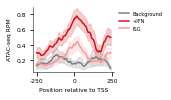

In [230]:
isg_df_to_use = isg_df.loc[isg_df.gene.isin(bonafide_isgs)]
null_df_to_use = null_df.loc[null_df.id.isin(bonafide_null_genes)]
sixhr_df_to_use = sixhr_df.loc[sixhr_df.gene.isin(bonafide_isgs)]

isg_mean = isg_df_to_use.groupby('pos')['rpm'].mean()
isg_sem = isg_df_to_use.groupby('pos')['rpm'].sem()
null_mean = null_df_to_use.groupby('pos')['rpm'].mean()
null_sem = null_df_to_use.groupby('pos')['rpm'].sem()
sixhr_mean = sixhr_df_to_use.groupby('pos')['rpm'].mean()
sixhr_sem = sixhr_df_to_use.groupby('pos')['rpm'].sem()

window = 10

isg_mean_smoothed = np.convolve(isg_mean, np.ones(window)/window, mode='valid')
null_mean_smoothed = np.convolve(null_mean, np.ones(window)/window, mode='valid')
sixhr_mean_smoothed = np.convolve(sixhr_mean, np.ones(window)/window, mode='valid')
isg_sem_smoothed = np.convolve(isg_sem, np.ones(window)/window, mode='valid')
null_sem_smoothed = np.convolve(null_sem, np.ones(window)/window, mode='valid')
sixhr_sem_smoothed = np.convolve(sixhr_sem, np.ones(window)/window, mode='valid')

fig, ax = plt.subplots(figsize=(4/2.5,3/2.5))

ax.fill_between(range(500-window+1), null_mean_smoothed-null_sem_smoothed,null_mean_smoothed+null_sem_smoothed, alpha=0.2, color=null_color)
ax.fill_between(range(500-window+1), sixhr_mean_smoothed-sixhr_sem_smoothed,sixhr_mean_smoothed+sixhr_sem_smoothed, alpha=0.2, color=sixhr_color)
ax.fill_between(range(500-window+1), isg_mean_smoothed-isg_sem_smoothed,isg_mean_smoothed+isg_sem_smoothed, alpha=0.2, color=isg_color)
ax.plot(null_mean_smoothed, label='Background', c=null_color)
ax.plot(sixhr_mean_smoothed, label='+IFN', c=sixhr_color)
ax.plot(isg_mean_smoothed, label='ISG', c=isg_color)

ax.set_xlabel('Position relative to TSS', fontsize = fontsize)
ax.set_xticks([0,250,500])
ax.set_xticklabels([-250,0,250], fontsize = fontsize)
ax.set_ylabel('ATAC-seq RPM', fontsize = fontsize)
ax.set_ylim(0.05,0.9)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8], fontsize = fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_box_aspect(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.get_legend().set_visible(False)
plt.legend(fontsize=legend_fontsize, markerscale=0.5, frameon=False, title='', title_fontsize=legend_fontsize, bbox_to_anchor=(1,1))

plt.savefig('{}/fig4_plots/isg_preaccessibility_by_atac.with_6hr.pdf'.format(output_path), dpi=300)

